<center><h1> Cleaning Process for Datasets</h1></center>

<left><h2>Dataset: MRI and Alzheimer's</h2></left>
<left><p>Source: <a href ="https://www.kaggle.com/datasets/jboysen/mri-and-alzheimers"> Kaggle Dataset from OASIS site </a></p></left>
<left><p>Source 2: <a href ="https://sites.wustl.edu/oasisbrains/"> OASIS site and Fact Sheet</a></p></left>
<left><p>Additional Readings:
<li><a href="https://dash.harvard.edu/server/api/core/bitstreams/7312037c-5b39-6bd4-e053-0100007fdf3b/content">Open Access Series of Imaging Studies (OASIS): Study from Journal of Cognitive Neuroscience</a></p></left>
<li> <a href="https://cgatoolkit.ca/Uploads/ContentDocuments/MMSE.pdf">Mini Mental State Examination (MMSE)</a>
<li> <a href="https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://stacks.cdc.gov/view/cdc/75315/cdc_75315_DS1.pdf&ved=2ahUKEwjt4s6si66QAxWzKFkFHeIRLY4QFnoECD0QAQ&usg=AOvVaw2iaHQBbQA2LPdNGNcqT4l2"> SES Hollingshead index (PDF)</a>


<h3>Initial DB Connection:</h3>
<p>This is the target for transfering the cleaned dataset into</p>

In [1]:
# Dependencies:
# pip install python-dotenv
# pip install psycopg2

import os
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import find_dotenv, load_dotenv


load_dotenv(find_dotenv(usecwd=True))

HOST = os.getenv("HOST")
PORT = os.getenv("PORT",5432)
DBNAME = os.getenv("DBNAME")
USER = os.getenv("USER")
PASSWORD = os.getenv("PASSWORD")
   
conn = psycopg2.connect(f"host={HOST} port={PORT} dbname={DBNAME} user={USER} password={PASSWORD} gssencmode=disable") 

try:
    conn.autocommit = True #
    cur = conn.cursor()
    cur.execute("""select
    t.table_name AS table_name,
    column_name,
    data_type
    from information_schema.tables t
    INNER JOIN information_schema.columns c on c.table_schema = c.table_schema AND t.table_name = c.table_name
    WHERE c.table_schema= 'mnemos'""") 
    df_db = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
    print(df_db)

except Exception as e:
    print(e)

finally:
    cur.close()

               table_name      column_name data_type
0      longitudinal_oasis        converted   boolean
1      longitudinal_oasis             nwbv   numeric
2      longitudinal_oasis              sex   boolean
3   cross_sectional_oasis              asf   numeric
4   cross_sectional_oasis             nwbv   numeric
5   cross_sectional_oasis              sex   boolean
6   cross_sectional_oasis   education_type   integer
7      longitudinal_oasis              cdr   numeric
8      longitudinal_oasis             etiv   integer
9      longitudinal_oasis             mmse   integer
10     longitudinal_oasis           mri_id      text
11     longitudinal_oasis     mmse_missing   boolean
12  cross_sectional_oasis              cdr   numeric
13     longitudinal_oasis            visit   integer
14     longitudinal_oasis               id      text
15     longitudinal_oasis         dementia   boolean
16     longitudinal_oasis              asf   numeric
17     longitudinal_oasis              ses   i

<h3>Initial Dataset Import and Investigation:</h3>

<p>Pandas can usually detect the datatypes in the dataframe, but some may need further investigation.</p>

<b>longitudual_oasis features:</b>
<ul>
<li>ID text
<li>Sex boolean             (F = 1, M = 0)
<li>Dominant_hand boolean  (Right=1, Left = 0)
<li>Age integer
<li>Education_type integer (1: less than high school grad, 2: highschool grad, 3: some college, 4: college grad, 5: beyond college)
<li>*SES integer (socioeconomic status) (1: highest SES status, 5: lowest SES status)
<li>MMSE integer (Mini-Mental State Examination)
<li>CDR float (Clinial Dementia Rating) (0: nondemented, 0.5: very mild dementia, 1: mild dementia, 2: moderate dementia)
<li>ETIV integer integer (Estimated total intracranial volume mm cubed)
<li>NWBV integer float (Normalized whole brain volume)
<li>ASF float (Atlas scaling factor)
<li>Delay integer(measured in days, the delay between visits. Will likely be omitted)
</li>
    
*SES is assumed to be using the Hollingshead index as the research papers I found regarding this OASIS dataset referred to it as such and I can find no other sources that contradict this.



In [2]:
df = pd.read_csv("oasis_longitudinal.csv")

indexList = ['ID', 'MRI_ID', 'Group' ,'Visit' , 'MRI_Delay','Sex','Dominant_Hand', 'Age', 'Education', 'SES', 'MMSE_Score', 'CDR', 'Estimated_Intracranial_Vol', 'Normalized_Brain_Vol','ASF']
df.columns = indexList

df.head()

,ID,MRI_ID,Group,Visit,MRI_Delay,Sex,Dominant_Hand,Age,Education,SES,MMSE_Score,CDR,Estimated_Intracranial_Vol,Normalized_Brain_Vol,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [3]:
na_list = list(df.columns[df.isna().any()])
print("Columns that need further investigation due to NaN values detection:", na_list ,"\n")

print(df.dtypes,"DETECTED CSV DATATYPES","\n")
print(f"Unique values for Group: {df['Group'].unique()}")
print(f"Unique values for Sex: {df['Sex'].unique()}")
print(f"Unique values for Dominant_Hand: {df['Dominant_Hand'].unique()}")
print(f"Unique values for Age: {df['Age'].unique()}")
print(f"Unique values for Education_Years: {df['Education'].unique()}")
print(f"Unique values for SES: {df['SES'].unique()}")
print(f"Unique values for CDR: {df['CDR'].unique()}")
print(f"Unique values for MMSE: {df['MMSE_Score'].unique()}")
print(f"Unique values for eITBV: {df['Estimated_Intracranial_Vol'].unique()}")
print(f"Unique values for Norm_eitbv: {df['Normalized_Brain_Vol'].unique()}")
print(f"Unique values for ASF: {df['ASF'].unique()}")


Columns that need further investigation due to NaN values detection: ['SES', 'MMSE_Score'] 

ID                             object
MRI_ID                         object
Group                          object
Visit                           int64
MRI_Delay                       int64
Sex                            object
Dominant_Hand                  object
Age                             int64
Education                       int64
SES                           float64
MMSE_Score                    float64
CDR                           float64
Estimated_Intracranial_Vol      int64
Normalized_Brain_Vol          float64
ASF                           float64
dtype: object DETECTED CSV DATATYPES 

Unique values for Group: ['Nondemented' 'Demented' 'Converted']
Unique values for Sex: ['M' 'F']
Unique values for Dominant_Hand: ['R']
Unique values for Age: [87 88 75 76 80 90 83 85 71 73 93 95 68 69 66 78 81 82 77 86 92 84 72 61
 64 74 60 62 91 79 89 70 94 97 65 67 63 96 98]
Unique values for E

<h3>Cleaning Process:</h3>

<p>After investigation, <b>2 columns appear to need immediate evaluation; SES and MMSE_Score.</b> In addition to columns with Nans, the feature 'Group' holds valuable information but could be broken out to be more modular for our purposes of model prediction. Since 'converted' means the patient was not initally diagnosed with dementia but later diagnosed they would fall under 'demented' but should have a separate flag that makes them stand out as a special case for identification.</p>

<ul>
<li><b>SES</b>: Nans in SES column will be normalized according to the median value in order to keep the dataset shape consistent to the original</li>
<li><b>MMSE_Score</b>: If there is only a small percentage of Nans, those rows could be dropped OR if it is not a small percentage, they can be flagged with a helper column
<li><b>MRI_Delay</b>: Will be dropped due to not a lot of information gain from this feature, for our purposes
<li><b>Group</b>: Will be broken up into two columns; 'Dementia' (Boolean) and 'Converted' (Boolean).



SES MEAN: 2.4604519774011298  SES MEDIAN: 2.0


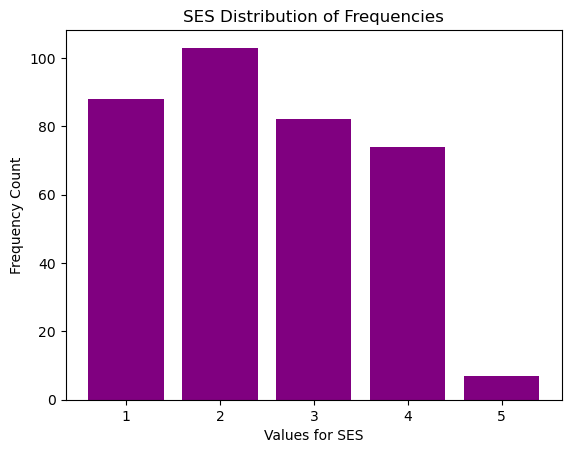

In [4]:
#MRI_Delay drop
df.drop('MRI_Delay', axis=1, inplace=True)

#SES fill-ins
ses_mean, ses_med = df['SES'].mean(), df['SES'].median()
ses_freq = df['SES'].value_counts()

print("SES MEAN:",ses_mean, " SES MEDIAN:",ses_med)

plt.bar(ses_freq.index,
        ses_freq.values,
       color='purple')
plt.xlabel('Values for SES')
plt.ylabel('Frequency Count')
plt.title('SES Distribution of Frequencies')
plt.show()

df['SES'] = df['SES'].fillna(2.0)

In [5]:
#MMSE drop or flag processing
mmse_na, mmse_total = df['MMSE_Score'].isna().sum(), len(df['MMSE_Score'])
print('NANS FOUND:', mmse_na, 'TOTAL MMSEs:' ,mmse_total, 'PERCENT of NANs:' ,mmse_na/mmse_total)

df.dropna(subset=['MMSE_Score'], inplace=True)
print(len(df))
#MMSE null rows are safe to drop since they make less than 2% of the total rows

NANS FOUND: 2 TOTAL MMSEs: 373 PERCENT of NANs: 0.005361930294906166
371


<h3>Conversion Process:</h3>
Now that all the NaN values are taken care of, the datatype conversions can be completed.
<ul>
<li> <b>Sex</b>: F will be encoded as 1, M will be encoded as 0
<li> <b>Dominant_Hand</b>: Left will be encoded as 1, R will be encoded as 0
<li> <b>Group</b>: Nondemented will be encoded as 0, demented will be encoded as 1; Group will exist as 'Dementia' in the table
<li> <b>Converted</b>: A new column to be added to help support the information from the original Group feature. 
</ul>

In [20]:
df = df.replace({'Sex' : {'F':1, 'M':0}, 'Dominant_Hand' : {'L': 1, 'R': 0}, 'Group' : {'Nondemented':0, 'Demented':1, 'Converted':2}})
# df = df.convert_dtypes()
df_split = df.assign(Converted=np.where(df['Group'] == 2, True, False))
df_split['Group'] = df_split['Group'].replace(2,1)

df_clean = df_split.convert_dtypes()


In [23]:
df_clean.to_csv('clean_oasis2.csv', index=False,  header=False)

try:
    conn.autocommit = True
    cur = conn.cursor()
    f = open('clean_oasis2.csv','r')
    cur.copy_from(f, 'longitudinal_oasis', sep=',')
except Exception as e:
    print(e)

finally:
    f.close()